In [7]:
!pip install contractions

In [8]:
from zipfile import ZipFile
import os

In [9]:
#!/bin/bash
!curl -L -o imdb-dataset-of-50k-movie-reviews.zip\
  https://www.kaggle.com/api/v1/datasets/download/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 25.7M  100 25.7M    0     0  43.8M      0 --:--:-- --:--:-- --:--:--  188M


In [10]:
with ZipFile('imdb-dataset-of-50k-movie-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('imdb-dataset')

### 1. Data Preprocessing

Data is very clean, there is no null value.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import contractions
import seaborn as sns
import random

In [12]:
df = pd.read_csv('imdb-dataset/IMDB Dataset.csv')
num_rows, num_cols = df.shape
df_train = df[:int(num_rows * 0.9)].copy()
df_test = df[int(num_rows * 0.9):].copy() #reserve 10% for testing

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [13]:
df_train.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [14]:
def text_preprocessing(text):
    text = text.lower()
    CLEANR = re.compile('<.*?>') 
    text = re.sub(CLEANR, '', text)# remove HTML tags
    text = contractions.fix(text)
    text = re.sub('[^a-zA-Z0-9\s]', ' ', text) # remove non-alphabetic characters
    return text

In [15]:
df_train.loc[:, 'review'] = df_train['review'].apply(text_preprocessing)
df_test.loc[:, 'review'] = df_test['review'].apply(text_preprocessing)
df_train['label'] = df_train['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [16]:
df_test['label'] = df_test['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [ ]:
df_train['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

### Tokenization

Normal padding works better for LSTM and Vanilla cell (tf.keras implementation), while GRU only accepts right padding (tf.keras implementation). Therefore, I used different padding styles.

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [89]:
max_features = 5000
tokenizer = Tokenizer(num_words = max_features, split=' ')
tokenizer.fit_on_texts(df_train['review'].values) #creates the vocabulary index based on word frequency
#it is actually word -> index mapping, lower index value means more frequent word
X = tokenizer.texts_to_sequences(df_train['review'].values)
X_pad = pad_sequences(X) #padding for batch optimization
X_rightpad = pad_sequences(X, padding = 'post')
Y = df_train['label']

In [90]:
X_test = tokenizer.texts_to_sequences(df_test['review'].values)
X_test_pad = pad_sequences(X_test)
X_test_rightpad = pad_sequences(X_test, padding = 'post')
Y_test = df_test['label']

## Train test split

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_pad, Y, 
                                                    test_size=0.2, 
                                                    shuffle = True,
                                                    stratify = Y,
                                                    random_state = 40 )
X_train_gru, X_val_gru, Y_train_gru, Y_val_gru = train_test_split(X_rightpad, Y, 
                                                    test_size=0.2, 
                                                    shuffle = True,
                                                    stratify = Y,
                                                    random_state = 40 )

## 2. RNNs
Overall architecture:
Embedding(n_features,128) --> Dropout(0.5) --> RNN(128,196) (either vanilla, lstm, gru cell with tanh activation) --> Dense(196,128) with relu -->  Dropout(0.4) --> Dense(128,1) with sigmoid --> Binary cross entropy

In [22]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU detected.")

GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [85]:
SEED = 42 
random.seed(SEED)  
np.random.seed(SEED) 
tf.random.set_seed(SEED)

In [60]:
def plotLoss(history, opt = 'hist'):
    plt.figure(figsize=(8, 5))
    if opt == 'hist':
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
    elif opt == 'dict':
        train_loss = history['loss']
        val_loss = history['val_loss']        
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

### Vanilla RNN

In [86]:
def vanilla_rnn(max_features=10000, emb_dim=50, rnn_dim=196):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=max_features, output_dim=emb_dim))
    model.add(tf.keras.layers.SpatialDropout1D(0.5))
    model.add(tf.keras.layers.SimpleRNN(rnn_dim, activation='tanh'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))  # Added ReLU activation
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [92]:
gpu_index = 0  # Change to the GPU index you want to use

with tf.device(f'/GPU:{gpu_index}'):
    model_vrnn = vanilla_rnn(max_features=max_features)

In [94]:
history = model_vrnn.fit(X_train, Y_train, epochs=12, batch_size=128, validation_data=(X_val, Y_val))

Epoch 1/12
282/282 ━━━━━━━━━━━━━━━━━━━━ 75s 258ms/step - accuracy: 0.4955 - loss: 0.7495 - val_accuracy: 0.5007 - val_loss: 0.6999
Epoch 2/12
282/282 ━━━━━━━━━━━━━━━━━━━━ 70s 248ms/step - accuracy: 0.5246 - loss: 0.6987 - val_accuracy: 0.6373 - val_loss: 0.6377
Epoch 3/12
282/282 ━━━━━━━━━━━━━━━━━━━━ 70s 248ms/step - accuracy: 0.6453 - loss: 0.6222 - val_accuracy: 0.6731 - val_loss: 0.5930
Epoch 4/12
282/282 ━━━━━━━━━━━━━━━━━━━━ 70s 248ms/step - accuracy: 0.7182 - loss: 0.5528 - val_accuracy: 0.7509 - val_loss: 0.5159
Epoch 5/12
282/282 ━━━━━━━━━━━━━━━━━━━━ 70s 248ms/step - accuracy: 0.7321 - loss: 0.5166 - val_accuracy: 0.6033 - val_loss: 0.6635
Epoch 6/12
282/282 ━━━━━━━━━━━━━━━━━━━━ 70s 248ms/step - accuracy: 0.6228 - loss: 0.6378 - val_accuracy: 0.6419 - val_loss: 0.6230
Epoch 7/12
282/282 ━━━━━━━━━━━━━━━━━━━━ 70s 249ms/step - accuracy: 0.6634 - loss: 0.5976 - val_accuracy: 0.6479 - val_loss: 0.6177
Epoch 8/12
282/282 ━━━━━━━━━━━━━━━━━━━━ 70s 249ms/step - accuracy: 0.6911 - loss: 0

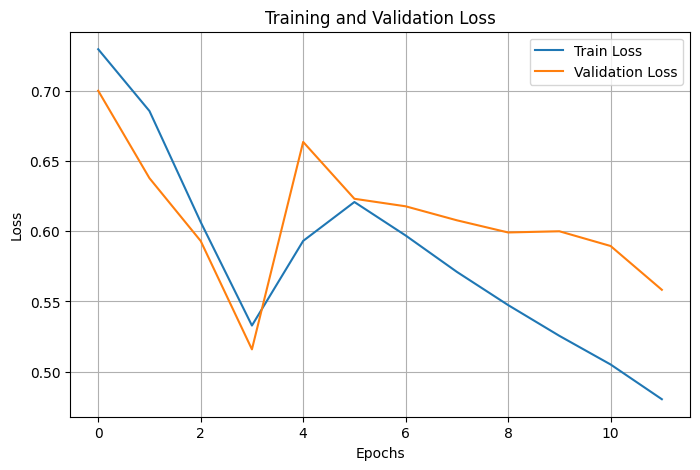

In [95]:
plotLoss(history)

In [98]:
score = model_vrnn.evaluate(X_test_pad, Y_test, verbose=False)
print("loss = ",score[0])
print("accuracy = ",score[1])

loss =  0.5488365888595581
accuracy =  0.7287999987602234


### LSTM

In [46]:
def lstm(max_features=10000, emb_dim=128, rnn_dim=196):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=max_features, output_dim=emb_dim))
    model.add(tf.keras.layers.SpatialDropout1D(0.5))
    model.add(tf.keras.layers.LSTM(196, dropout = 0.3, recurrent_dropout = 0.3 ))
    model.add(tf.keras.layers.Dense(128, activation='relu'))  # Added ReLU activation
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [47]:
with tf.device(f'/GPU:{gpu_index}'):
    model_lstm = lstm(max_features=max_features)

In [48]:
history2 = model_lstm.fit(X_train, Y_train, epochs=5, batch_size=256, validation_data=(X_val, Y_val))

Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - accuracy: 0.6490 - loss: 0.6022 - val_accuracy: 0.8350 - val_loss: 0.3796
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 482s 3s/step - accuracy: 0.8364 - loss: 0.3869 - val_accuracy: 0.8343 - val_loss: 0.3745
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step - accuracy: 0.8568 - loss: 0.3514 - val_accuracy: 0.8564 - val_loss: 0.3428
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.8601 - loss: 0.3371 - val_accuracy: 0.8627 - val_loss: 0.3369
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.8641 - loss: 0.3306 - val_accuracy: 0.6264 - val_loss: 0.5891


In [50]:
history2_2 = model_lstm.fit(X_train, Y_train, epochs=1, batch_size=256, validation_data=(X_val, Y_val))

141/141 ━━━━━━━━━━━━━━━━━━━━ 475s 3s/step - accuracy: 0.7650 - loss: 0.4847 - val_accuracy: 0.8628 - val_loss: 0.3339


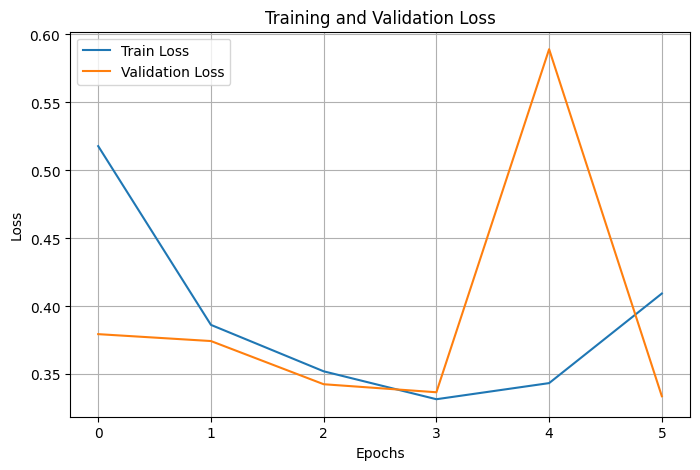

In [62]:
def merge_histories(history1, history2):
    merged_history = {}
    for key in history1.history.keys():
        merged_history[key] = history1.history[key] + history2.history[key]
    return merged_history
history2_comb = merge_histories(history2, history2_2)
plotLoss(history2_comb, 'dict')

In [99]:
score = model_lstm.evaluate(X_test_pad, Y_test, verbose=False)
print("loss = ",score[0])
print("accuracy = ",score[1])

loss =  0.34050968289375305
accuracy =  0.8578000068664551


### Gru

In [104]:
def gru(max_features=5000, emb_dim=128, rnn_dim=196):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=max_features, output_dim=emb_dim, mask_zero=True))
    model.add(tf.keras.layers.SpatialDropout1D(0.3))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(tf.keras.layers.GRU(rnn_dim))
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.LeakyReLU(negative_slope=0.1))  # Prevents dying neurons
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [113]:
with tf.device(f'/GPU:{gpu_index}'):
    model_gru = gru(max_features=max_features)

In [114]:
history3 = model_gru.fit(X_train_gru, Y_train_gru, epochs=3, batch_size=256, validation_data=(X_val_gru, Y_val_gru))

Epoch 1/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.6757 - loss: 0.5719 - val_accuracy: 0.8440 - val_loss: 0.3664
Epoch 2/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - accuracy: 0.8675 - loss: 0.3276 - val_accuracy: 0.8753 - val_loss: 0.3379
Epoch 3/3
141/141 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - accuracy: 0.9063 - loss: 0.2379 - val_accuracy: 0.8812 - val_loss: 0.3086


## 3. Compare 3 models
* Performance: GRU gives the highest accuracy among the models, next is LSTM, lowest is vanilla RNN
* Time cost: LSTM takes longest time.

Explanation of the result:

Perhaps sentiment analysis performance are being significantly influenced by the long-term dependencies, so models with memory perform much bettter. Also, because LSTM has addtional gates in comparision with GRU, its architecture is more complicated, making the training takes longer and consume more memory.

In [117]:
def evaluate_test(model, model_name, X_test, Y_test):
    score = model.evaluate(X_test, Y_test, verbose=False)
    print(model_name)
    print("loss = ",score[0])
    print("accuracy = ",score[1])
    print('\n')

In [120]:
evaluate_test(model_vrnn, 'Vanilla RNN', X_test_pad, Y_test)
evaluate_test(model_lstm, 'LSTM', X_test_pad, Y_test)
evaluate_test(model_gru, 'GRU', X_test_rightpad, Y_test)

Vanilla RNN
loss =  0.5488365888595581
accuracy =  0.7287999987602234


LSTM
loss =  0.34050968289375305
accuracy =  0.8578000068664551


GRU
loss =  0.29593175649642944
accuracy =  0.8930000066757202


